<a href="https://colab.research.google.com/github/jin573/studyDeepLearning/blob/main/doit5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [3]:
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)


In [4]:
from sklearn.linear_model import SGDClassifier

In [5]:
#훈련 노하우!
#검증 세트를 나누고 전처리 과정
#hinge 함수 (서포트 벡터 머신) : 다른 손실 함수

#모델 파라미터: 가중치와 같이 모델이 학습하는 값
#하이퍼 파라미터: 사람이 정해주어야 하는 값(클래스, 메서드의 매개변수로 전달) -> 어떤게 좋은지 여러번 수정하면서 알아야 한다

#테스트 세트로 튜닝하면 실전에 사용할 때 성능 차이가 생길 수 있다!
#-> 왜? 테스트 세트에 훈련되어서
sgd = SGDClassifier(loss='log_loss', random_state=42)
sgd.fit(x_train_all, y_train_all)
a= sgd.score(x_test, y_test)

print(a)

sgd = SGDClassifier(loss='hinge', random_state=42)
sgd.fit(x_train_all, y_train_all)
b= sgd.score(x_test, y_test)

print(b)

0.8333333333333334
0.9385964912280702


In [6]:
#훈련 세트 60% 검증 세트 20% 테스트 세트 20%로 나누자
#검증 세트에서 하이퍼 파라미터 튜닝을 여러번 반복하여 베스트를 찾음 -> 테스트 세트에서 일반화 성능 추정
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)
print(len(x_train), len(x_val))


sgd = SGDClassifier(loss='log_loss', random_state=42)
sgd.fit(x_train, y_train)
sgd.score(x_val, y_val)

364 91


0.6923076923076923

['mean perimeter' 'mean area']


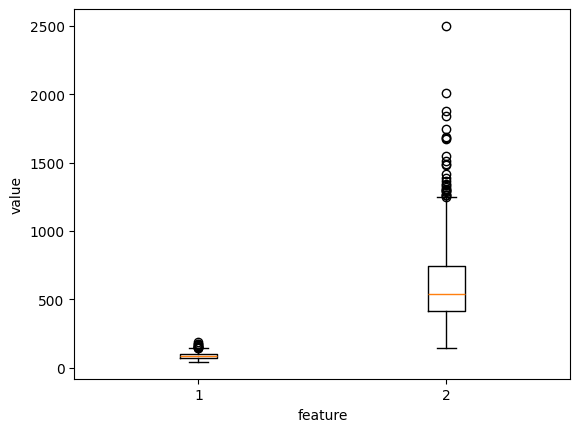

In [7]:
#속성들의 값 범위가 다르면 스케일이 다르다고 표현
#스케일이 달라서 가중치 업데이트 범위도 달라짐 -> 특성의 스케일을 바꾸어 줘야함
print(cancer.feature_names[[2,3]])
plt.boxplot(x_train[:, 2:4])
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

In [8]:
#예제 모델
class SingleLayer:

    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses = []
        self.w_history = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2

    def forpass(self, x):
        z = np.sum(x * self.w) + self.b    # 직선 방정식을 계산합니다
        return z

    def backprop(self, x, err):
        w_grad = x * err          # 가중치에 대한 그래디언트를 계산합니다
        b_grad = 1 * err    # 절편에 대한 그래디언트를 계산합니다
        return w_grad, b_grad

    def activation(self, z):
        z = np.clip(z, -100, None) # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + np.exp(-z))  # 시그모이드 계산
        return a

    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.w = np.ones(x.shape[1])               # 가중치를 초기화합니다.
        self.b = 0                                 # 절편을 초기화합니다.
        self.w_history.append(self.w.copy())       # 가중치를 기록합니다.
        np.random.seed(42)                         # 랜덤 시드를 지정합니다.
        for i in range(epochs):                    # epochs만큼 반복합니다.
            loss = 0
            # 인덱스를 섞습니다
            indexes = np.random.permutation(np.arange(len(x)))
            for i in indexes:                      # 모든 샘플에 대해 반복합니다
                z = self.forpass(x[i])             # 정방향 계산
                a = self.activation(z)             # 활성화 함수 적용
                err = -(y[i] - a)                  # 오차 계산
                w_grad, b_grad = self.backprop(x[i], err) # 역방향 계산
                # 그래디언트에서 페널티 항의 미분 값을 더합니다
                w_grad += self.l1 * np.sign(self.w) + self.l2 * self.w
                self.w -= self.lr * w_grad         # 가중치 업데이트
                self.b -= self.lr * b_grad         # 절편 업데이트
                # 가중치를 기록합니다.
                self.w_history.append(self.w.copy())
                # 안전한 로그 계산을 위해 클리핑한 후 손실을 누적합니다
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))
            # 에포크마다 평균 손실을 저장합니다
            self.losses.append(loss/len(y) + self.reg_loss())
            # 검증 세트에 대한 손실을 계산합니다
            self.update_val_loss(x_val, y_val)

    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]     # 정방향 계산
        return np.array(z) >= 0                   # 스텝 함수 적용

    def score(self, x, y):
        return np.mean(self.predict(x) == y)

    def reg_loss(self):
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2) #둘 다 사용. 둘 다 사용할 지 하나만 사용할 지는 문제 상황에 따라 결정해야 한다.

    def update_val_loss(self, x_val, y_val):
        if x_val is None:
            return
        val_loss = 0
        for i in range(len(x_val)):
            z = self.forpass(x_val[i])     # 정방향 계산
            a = self.activation(z)         # 활성화 함수 적용
            a = np.clip(a, 1e-10, 1-1e-10)
            val_loss += -(y_val[i]*np.log(a)+(1-y_val[i])*np.log(1-a))
        self.val_losses.append(val_loss/len(y_val) + self.reg_loss())

In [9]:
layer1 = SingleLayer()
layer1.fit(x_train, y_train)
layer1.score(x_val, y_val)

0.9120879120879121

In [10]:
#학습률
#가중치를 업데이트할 때 최솟값을 지나칠 경우를 고려해 학습률을 곱한다
#그래서 학습률은 아주 작은값

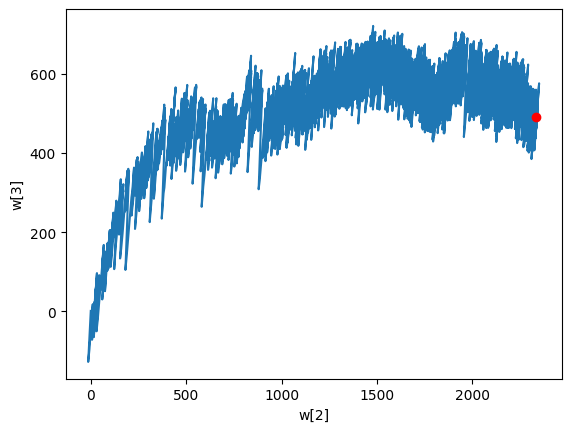

In [11]:
w2 = []
w3 = []
for w in layer1.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

In [12]:
#표준화: 각 행과 열의 평균을 구해 스케일을 조정해 모델을 훈련하는 방법
#필수적이다!

In [13]:
train_mean = np.mean(x_train, axis=0)
train_std = np.std(x_train, axis=0)
x_train_scaled = (x_train - train_mean) / train_std

In [14]:
layer2 = SingleLayer()
layer2.fit(x_train_scaled, y_train)

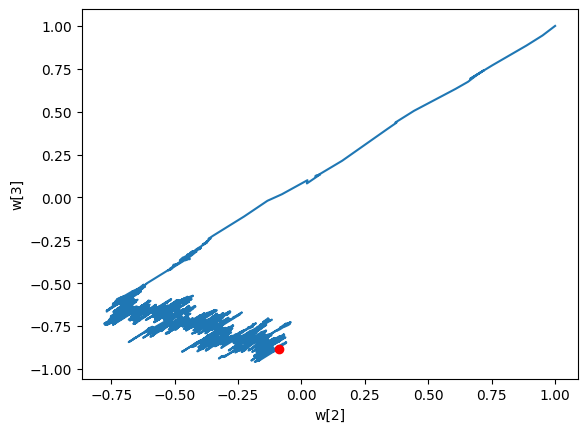

In [15]:
w2 = []
w3 = []
for w in layer2.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

In [16]:
layer2.score(x_val, y_val)

0.37362637362637363

In [17]:
#검증 세트로 성능 평가하기!
#x_train을 표준화 시킴 -> x_val은 어떻게 처리해야 할까? -> x_val도 똑같이 표준화
#다만, 산점도로 추출했을 때 위치가 변한다 (나누는 값이 달라져서)
#따라서 훈련 데이터의 평균과 표준편차를 사용해야 한다

In [18]:
val_mean = np.mean(x_val, axis=0)
val_std = np.std(x_val, axis=0)
x_val_scaled = (x_val - val_mean) / val_std

In [19]:
layer2.score(x_val_scaled, y_val)

0.967032967032967

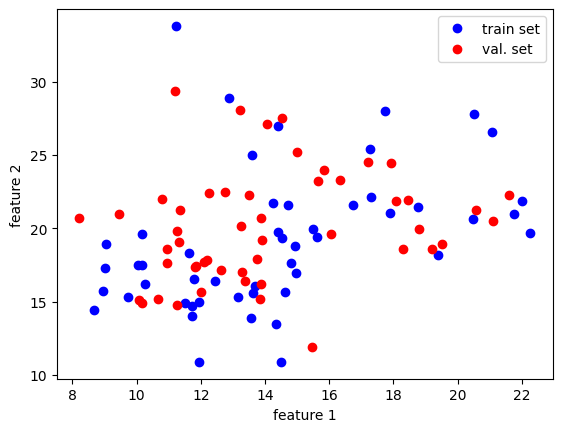

In [20]:
plt.plot(x_train[:50, 0], x_train[:50, 1], 'bo')
plt.plot(x_val[:50, 0], x_val[:50, 1], 'ro')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val. set'])
plt.show()

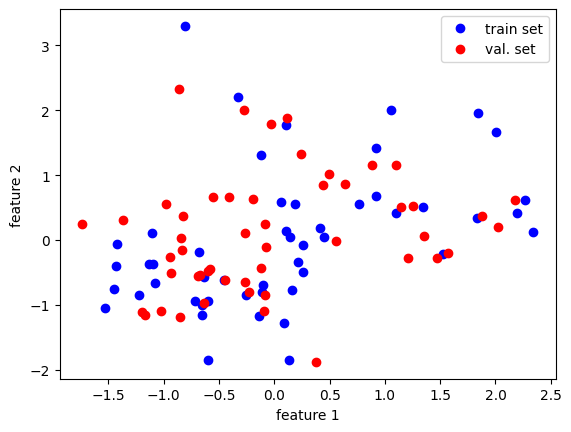

In [21]:
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50, 1], 'ro')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val. set'])
plt.show()

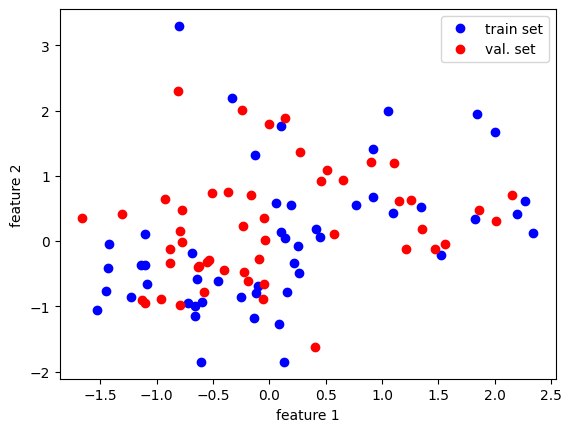

In [22]:
#다시 표준화 진행
x_val_scaled = (x_val - train_mean) / train_std

plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50, 1], 'ro')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val. set'])
plt.show()

In [23]:
layer2.score(x_val_scaled, y_val)

0.967032967032967

In [24]:
#훈련 세트와 검증 세트를 비교해보자
#훈련 세트의 크기와 정확도로 비교하는 방법이 있다
#과대 적합: 훈련은 잘 되었는데 검증 세트에서 정확도가 떨어짐(분산이 큼)
#과소 적합: 훈련 세트와 검증 세트가 비슷하지만, 기대하는 정확도에서 멀다 (편향이 큼)

#우선 과대 적합 시키고 과소 적합을 통해 적절한 모델을 만듦.

#과대 적합 시키는 방법: 뉴런 개수를 늘리거나 층을 여러개
#과소 적합 시키는 방법: 가중치 규제, 드롭 아웃, 뉴런 개수 줄이기

#에포크가 늘어날 수록 과대 적합된 모델이 만들어질 수 있음. 하지만 검증 세트가 어느 지점 부터는 적합하지 않다고 판단됨
#에포크가 늘어날 수록 정확도가 늘어나지만 어느 지점 부터는 검증 세트의 적합도가 떨어짐

#적절한 편향 - 분산 트레이드오프를 선택하자

In [25]:
layer3 = SingleLayer()
layer3.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

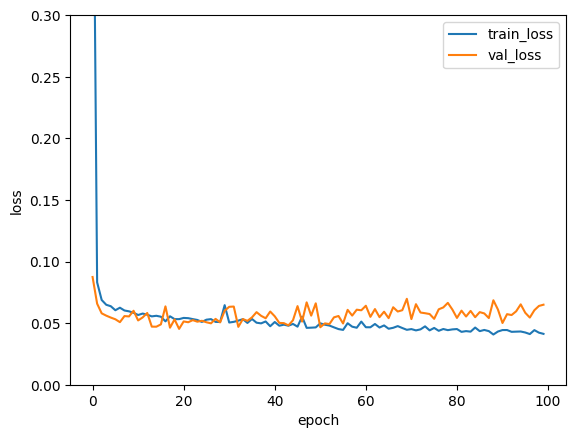

In [26]:
plt.ylim(0, 0.3)
plt.plot(layer3.losses)
plt.plot(layer3.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [27]:
layer4 = SingleLayer()
layer4.fit(x_train_scaled, y_train, epochs=30) #조기 종료 훈련세트와 검증세트 계산
layer4.score(x_val_scaled, y_val)

0.978021978021978

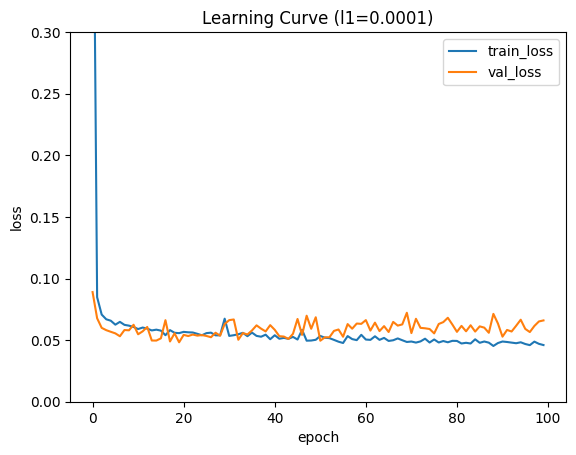

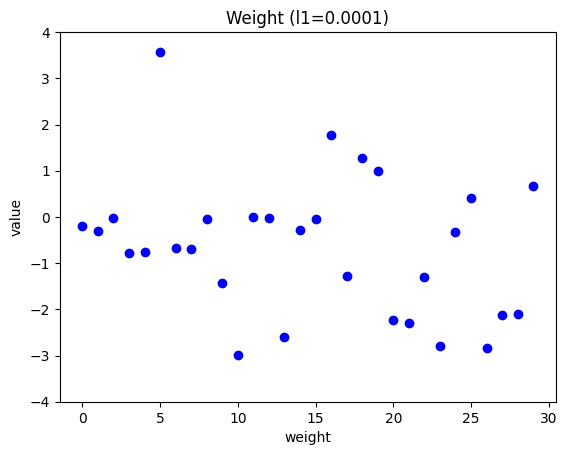

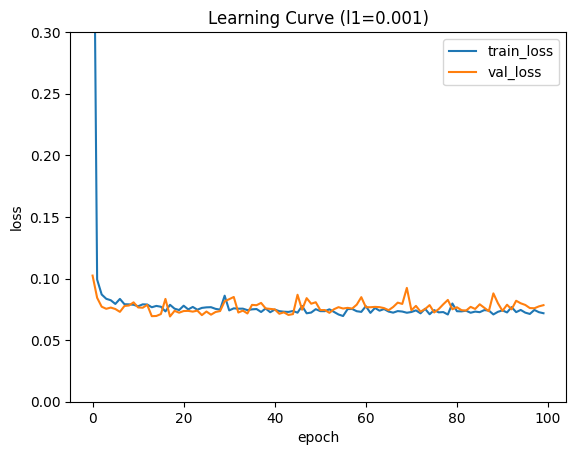

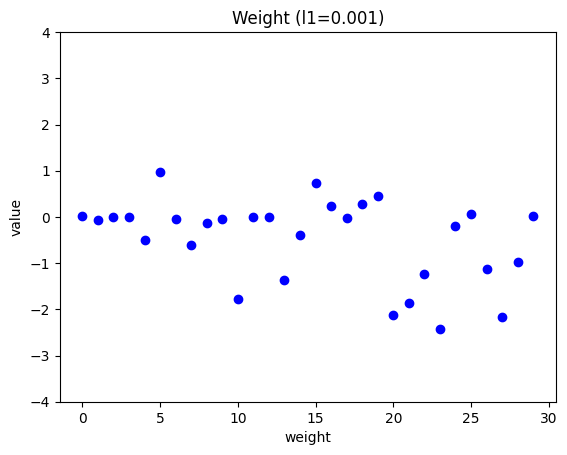

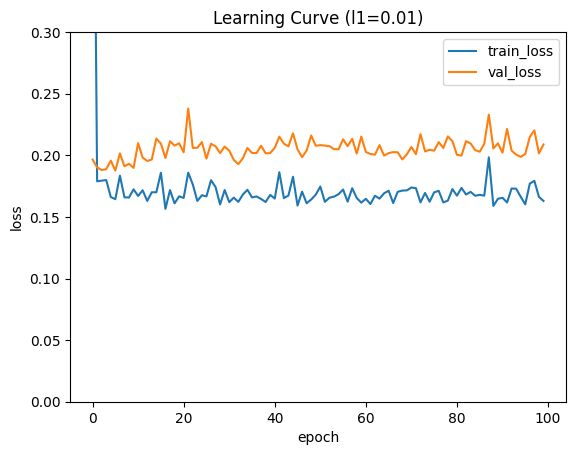

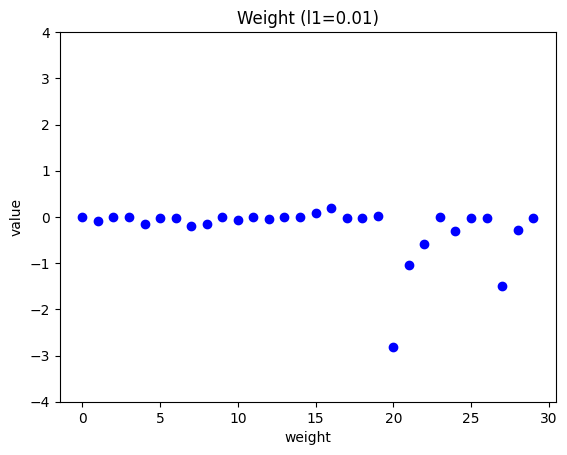

In [28]:
#그래프의 기울기가 작을 수록 일반화 좋다 = 가중치가 작을 수록 좋다
#L1 규제
#손실 함수에 가중치 값을 추가 -> 손실 함수를 낮춰야 하니 가중치 값을 높이지 않으려고 함
#손실 함수에 가중치 절댓값 합을 추가 -> 미분 시 부호를 가지게
#w_grad += alpha * np.sign(w)

#L2 규제 (많이 사용된다)
#손실 함수에 가중치 제곱 합을 추가 -> 미분해도 0보다 크다
#가중치가 큰 영향을 미침
#w_grad += alpha * w

#사이킷런에서 ElasticNet으로 선형 회귀 + L1/L2


l1_list = [0.0001, 0.001, 0.01]

for l1 in l1_list:
    lyr = SingleLayer(l1=l1)
    lyr.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

    plt.plot(lyr.losses)
    plt.plot(lyr.val_losses)
    plt.title('Learning Curve (l1={})'.format(l1))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'])
    plt.ylim(0, 0.3)
    plt.show()

    plt.plot(lyr.w, 'bo')
    plt.title('Weight (l1={})'.format(l1))
    plt.ylabel('value')
    plt.xlabel('weight')
    plt.ylim(-4, 4)
    plt.show()

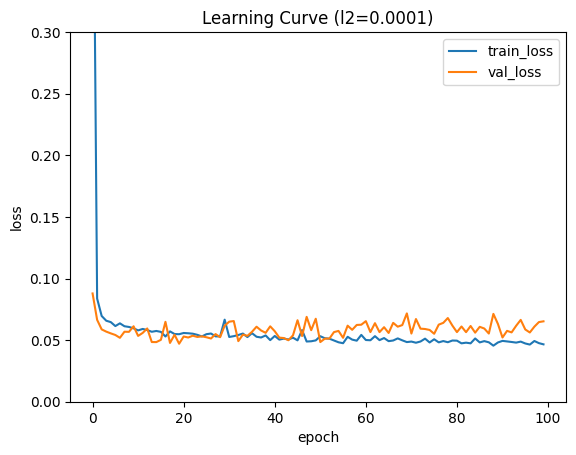

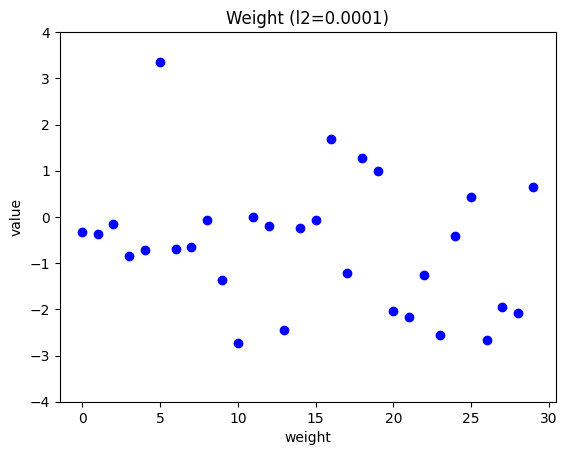

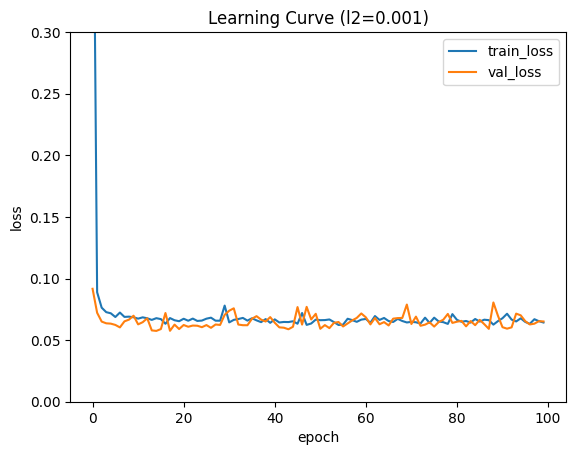

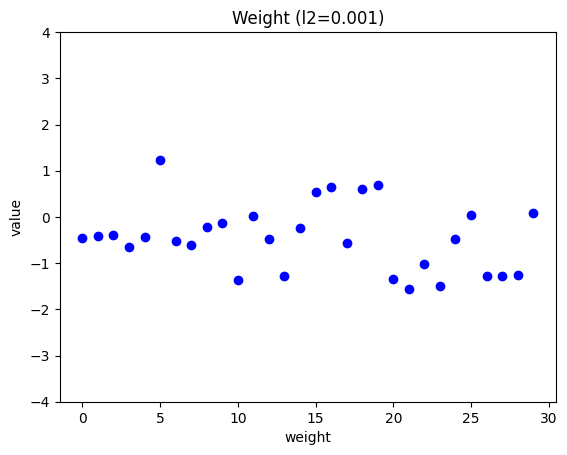

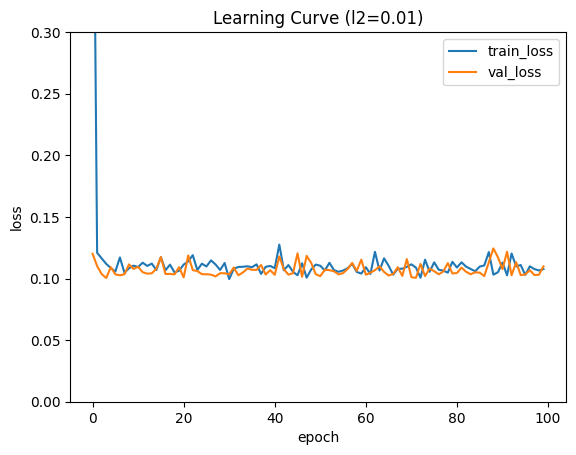

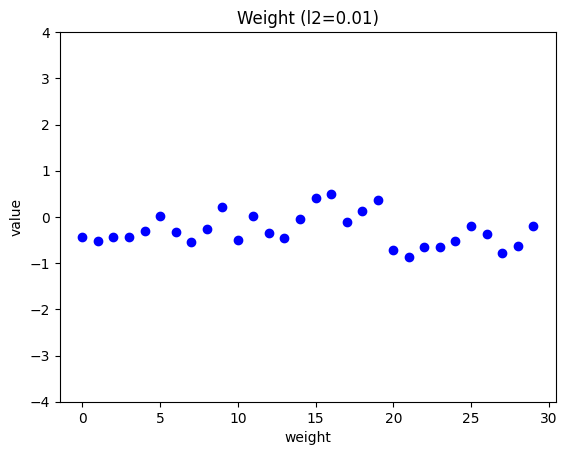

In [29]:
l2_list = [0.0001, 0.001, 0.01]

for l2 in l2_list:
    lyr = SingleLayer(l2=l2)
    lyr.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

    plt.plot(lyr.losses)
    plt.plot(lyr.val_losses)
    plt.title('Learning Curve (l2={})'.format(l2))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'])
    plt.ylim(0, 0.3)
    plt.show()

    plt.plot(lyr.w, 'bo')
    plt.title('Weight (l2={})'.format(l2))
    plt.ylabel('value')
    plt.xlabel('weight')
    plt.ylim(-4, 4)
    plt.show()

In [ ]:
#교차 검증
#검증 세트를 훈련 세트에서 분리하였음 -> 훈련 세트가 줄어든다면 좋지 않다! -> 교차 검증
#데이터 세트에서 테스트 세트를 제외하고 폴드로 분리
#각 폴드마다 검증 폴드로 사용하고 평균을 내어 최종 성능

In [31]:
from sklearn.model_selection import cross_validate
sgd = SGDClassifier(loss='log_loss', penalty='l2', alpha=0.001, random_state=42)
scores = cross_validate(sgd, x_train_all, y_train_all, cv=10) #10개로 나눔
print(np.mean(scores['test_score']))

#딥러닝에서는 잘 안쓴다 -> 훈련 데이터가 너무 커서 반복하는 것은 자원의 낭비가 될 수 있음

0.850096618357488


In [32]:
#파이프라인 클래스를 사용해서 전처리와 모델을 하나의 파이프라인으로 정의
#훈련 세트에서 전처리 통곗값을 얻은 뒤에 검증세트를 전처리 해야한다
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
pipe = make_pipeline(StandardScaler(), sgd) #표준화함수와 경사하강법 모델을 파이프라인으로 만든다
scores = cross_validate(pipe, x_train_all, y_train_all, cv=10, return_train_score=True)#교차검증 안에 전처리 과정이 포함 되어야 함
print(np.mean(scores['test_score']))

0.9694202898550724
